In [18]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.set_default_dtype(torch.float64)

In [19]:
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            if spectral:
                self.dense[str(i)] = spectral_norm(nn.Linear(neurons[i], neurons[i+1]))
            else:
                self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            
            if activation==torch.sin:
                c = torch.sqrt(torch.tensor(6.))
                numerator = torch.sqrt(torch.tensor(neurons[i]).double())
                nn.init.uniform_(self.dense[str(i)].weight, a=-c/numerator, b=c/numerator)
                nn.init.zeros_(self.dense[str(i)].bias)
            else:
                nn.init.xavier_uniform_(self.dense[str(i)].weight)
                nn.init.zeros_(self.dense[str(i)].bias)                
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [20]:
device='cuda'
torch.manual_seed(0)

dim_x = 1
dim_z = 2
f_sensors = 41
b_sensors = 1
B_size=32
B_x = torch.randn([dim_x,B_size//2], device=device)
B_z = torch.randn([dim_z,B_size//2], device=device)

save_path='WGANSN_PCN_SD'
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(save_path+'/B_x.pickle', 'wb') as f:
    pickle.dump(B_x, f, pickle.HIGHEST_PROTOCOL)
with open(save_path+'/B_z.pickle', 'wb') as f:
    pickle.dump(B_z, f, pickle.HIGHEST_PROTOCOL)

p=32
net_size_ux = [B_size,32,32,p]
net_size_uz = [B_size,32,32,p]
net_size_D = [f_sensors+b_sensors,64,64,1]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

def FEz(x):
    x_sin = torch.sin(torch.matmul(x,B_z))
    x_cos = torch.cos(torch.matmul(x,B_z))
    return torch.concat([x_cos,x_sin],-1)

acti = torch.sin
ux = DNN(net_size_ux, activation=acti).to(device)
uz = DNN(net_size_uz, activation=acti).to(device)
D = DNN(net_size_D, activation=torch.relu, spectral=True).to(device)

def GU(X, Z):
    X_FE = FEx(X)
    Z = FEz(Z)
    outx = acti(ux(X_FE))
    outz = uz(Z)
    out = torch.matmul(outz,outx.T)
    return out

def b_tilde(X,Z):
    return GU(X,Z)

def f_tilde(X,Z):
    u = GU(X,Z)
    
    dummy = torch.ones(u.shape, device=device, requires_grad=True)
    tmp = grad(u, X, grad_outputs=dummy, create_graph=True)[0]
    u_x = grad(tmp[:,0].sum(), dummy, create_graph=True)[0]
    return u_x


In [21]:
N_train = 1000
x_f = torch.linspace(0,1,f_sensors, device=device, requires_grad=True).reshape(-1,1)
x_b = torch.zeros([b_sensors,1], device=device)
xi = torch.randn([N_train,2], device=device)

cpnt_x = -np.pi*torch.sin(np.pi*x_f)
cpnt_x = torch.concat([cpnt_x,-np.pi/2*torch.sin(np.pi/2*x_f)],-1)
cpnt_x = torch.concat([cpnt_x,-np.pi/4*torch.sin(np.pi/4*x_f)],-1)
cpnt_x = cpnt_x.reshape(1,f_sensors,3)

cpnt_xi = torch.ones([N_train,1], device=device)
cpnt_xi = torch.concat([cpnt_xi,xi],-1)
cpnt_xi = cpnt_xi.reshape(N_train, 1, 3)

with torch.no_grad():
    f_data = (cpnt_x*cpnt_xi).sum(-1)
    b_data = cpnt_xi.sum(-1)

In [22]:
def compute_lossD(Z, B, F):
    B_gen = b_tilde(x_b, Z)
    F_gen = f_tilde(x_f, Z)

    Dreal = D(B, F)
    Dfake = D(B_gen,F_gen)
    lossD = Dreal.mean()-Dfake.mean()
    
    return -lossD

def compute_lossG(Z):
    B_gen = b_tilde(x_b, Z)
    F_gen = f_tilde(x_f, Z)
    
    Dfake = D(B_gen,F_gen)
    lossG = -Dfake.mean()
    return lossG

def updateD(Z,B,F):
    optimizerD.zero_grad()
    lossD = compute_lossD(Z,B,F)
    lossD.backward()
    optimizerD.step()

def updateG(Z):
    optimizerG.zero_grad()
    lossG = compute_lossG(Z)
    lossG.backward()
    optimizerG.step()

In [23]:
torch.manual_seed(0)

D_params = list(D.parameters())
G_params = list(ux.parameters())+list(uz.parameters())
optimizerD = torch.optim.RMSprop(D_params, lr=2e-4)
optimizerG = torch.optim.RMSprop(G_params, lr=5e-5)

num_epochs = 10000
st = time.time()
for epoch in range(num_epochs):
    z = torch.randn([N_train,dim_z], device=device)
    alpha = torch.randn([N_train,1], device=device)
    updateD(z, b_data, f_data)
    updateG(z)
torch.save(D.state_dict(), save_path+'/paramsD')
torch.save(ux.state_dict(), save_path+'/paramsux')
torch.save(uz.state_dict(), save_path+'/paramsuz')

print(f"{time.time()-st} seconds")

104.71177339553833 seconds


In [24]:
torch.manual_seed(0)

N_test = 20000
m_test = 101
x_test = torch.linspace(0,1,m_test, device=device).reshape(-1,1)
with torch.no_grad():
    z_test = torch.randn([N_test,dim_z],device=device)
    u_gen = GU(x_test, z_test).cpu()
    u_mean, u_std = u_gen.mean(0), u_gen.std(0)

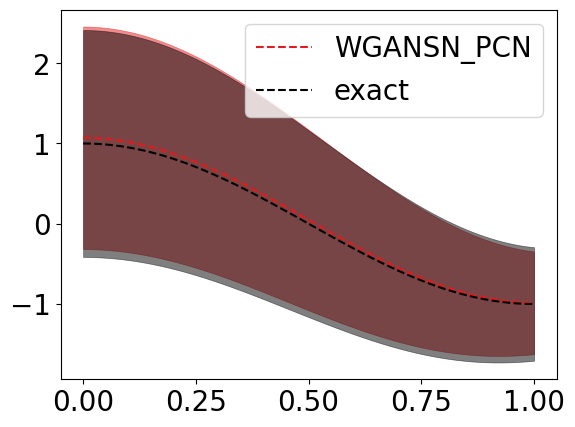

In [25]:
colors = [plt.cm.Paired(i) for i in range(20)]
x_test_ = x_test.flatten().cpu()

u_mean_ref = torch.cos(np.pi*x_test_)
u_std_ref = torch.sqrt(torch.cos(np.pi/2*x_test_)**2+torch.cos(np.pi/4*x_test_)**2)

plt.plot(x_test_,u_mean,'--',label='WGANSN_PCN', color=colors[5])
plt.fill_between(x_test_, u_mean+u_std, u_mean-u_std, alpha=0.5, linewidth=.5, color=colors[5])

plt.plot(x_test_.flatten(),u_mean_ref, '--',label='exact', color='k')
plt.fill_between(x_test_, u_mean_ref+u_std_ref, u_mean_ref-u_std_ref, alpha=0.5, linewidth=.5, color='k')
plt.legend()

In [26]:
x_test.requires_grad=True
f_gen = f_tilde(x_test,z_test).cpu()
b_gen = b_tilde(torch.zeros([b_sensors,1], device=device), z_test).cpu()
with torch.no_grad():
    f_mean, f_std = f_gen.mean(0), f_gen.std(0)
    b_mean, b_std = b_gen.mean(0), b_gen.std(0)
    cor = (b_gen-b_mean)*(f_gen-f_mean)
    cor = cor.mean(0)

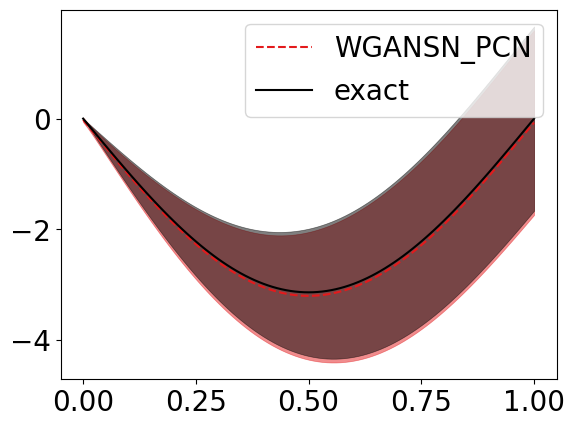

In [27]:
colors = [plt.cm.Paired(i) for i in range(20)]

f_mean_ref = -np.pi*torch.sin(np.pi*x_test_)
f_std_ref = torch.sqrt((np.pi/2*torch.sin(np.pi/2*x_test_))**2+(np.pi/4*torch.sin(np.pi/4*x_test_))**2)
b_mean_ref = torch.ones([1,1])

plt.plot(x_test_,f_mean,'--',label='WGANSN_PCN', color=colors[5])
plt.fill_between(x_test_, f_mean+f_std, f_mean-f_std, alpha=0.5, linewidth=.5, color=colors[5])

plt.plot(x_test_.flatten(),f_mean_ref, '-',label='exact', color='k')
plt.fill_between(x_test_, f_mean_ref+f_std_ref, f_mean_ref-f_std_ref, alpha=0.5, linewidth=.5, color='k')
plt.legend()

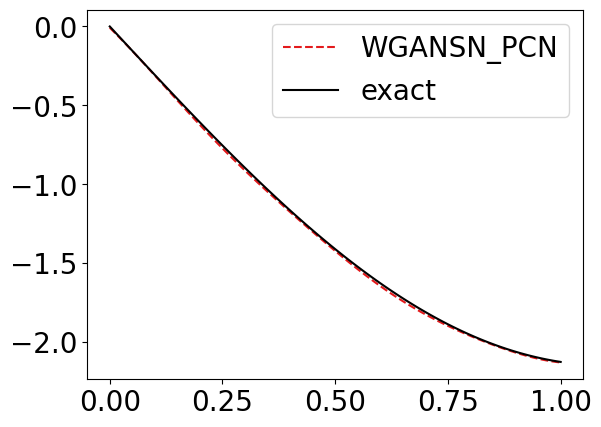

In [28]:
colors = [plt.cm.Paired(i) for i in range(20)]

cor_ref = -np.pi/2*torch.sin(np.pi/2*x_test_)-np.pi/4*torch.sin(np.pi/4*x_test_)

plt.plot(x_test_,cor,'--',label='WGANSN_PCN', color=colors[5])
plt.plot(x_test_.flatten(),cor_ref, '-',label='exact', color='k')
plt.legend()

In [ ]:
!kill -9 {os.getpid()}